In [5]:
import features as ft
t_data = ft.gen_transfered_dist_feature()

S:\anaconda\envs\tf\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
S:\anaconda\envs\tf\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


read the data for transfered_dist_features_train
data for transfered_dist_features_train read


In [6]:
import pandas as pd
import numpy as np
from time import time

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import log_loss

from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
%matplotlib inline
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
from IPython import get_ipython

rand_number = 42

In [7]:
def one_hot(y):
    oc = OneHotEncoder(categories='auto')
    y_r = y.reshape(-1,1)
    oc.fit(y_r)
    r = oc.transform(y_r).toarray()
    return r


def get_log_loss(y_true, y_pred):
    y_p = one_hot(y_pred)
    return log_loss(y_true, y_p)

In [8]:
out_features = ['question1', 'question2', 'is_duplicate']
features = [x for x in t_data.columns if x not in out_features]
len(features)

164

In [9]:
t_data = t_data[t_data!=np.inf].dropna()
feature_data = t_data.drop_duplicates(features, keep='last')
input_data = feature_data[features]
input_data = input_data.astype(np.float64)
result = feature_data[['is_duplicate']]
result = result.values.ravel()

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_data, result, test_size = 0.2, random_state = 0,
                                                    stratify = result)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,
#                                                     stratify = y_train)

In [11]:
X_train.shape, X_test.shape, input_data.shape

((320910, 164), (80228, 164), (401138, 164))

In [10]:
rf_clf = RandomForestClassifier(random_state=rand_number)
gbdt_clf = GradientBoostingClassifier(random_state=rand_number)
lr_clf = LogisticRegression(random_state=rand_number)
sgd_clf = SGDClassifier(random_state=rand_number)
xgb_clf = XGBClassifier(random_state=rand_number)
lgb_clf = LGBMClassifier(random_state=rand_number)

models=[(rf_clf, "RandomForest"), (gbdt_clf, "GBDT"), (lr_clf, "LogsitcRegression"), (sgd_clf, "SGD"), 
        (xgb_clf, "XGBoost"), 
        (lgb_clf, "lightGBM")
       ]

for t in models:
    model, name = t
    t_start = time()
    model.fit(X_train, y_train)
    t_end = time()
    y_predprob = model.predict(X_train)
    print(name, "training time cost:", (t_end-t_start))
    y_t = model.predict(X_test)
    res = [
#         roc_auc_score(y_train, y_predprob), roc_auc_score(y_test, y_t), 
#            fbeta_score(y_train, y_predprob, beta=1), fbeta_score(y_test, y_t, beta=1),
#            accuracy_score(y_train, y_predprob), accuracy_score(y_test, y_t),
           get_log_loss(y_train, y_predprob), get_log_loss(y_test, y_t)
          ]
    print(res)

S:\anaconda\envs\tf\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForest training time cost: 61.46739077568054
[0.3218065545504448, 7.736654915901431]
GBDT training time cost: 643.6953117847443
[8.178083962379752, 8.225281221034596]


S:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogsitcRegression training time cost: 306.7853162288666
[8.930508585410578, 8.890415706876658]


S:\anaconda\envs\tf\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGD training time cost: 1.9209864139556885
[12.725242866460588, 12.724948305837987]
XGBoost training time cost: 445.6298062801361
[8.306698956589713, 8.35443354838257]
lightGBM training time cost: 56.26741313934326
[7.0712416189025795, 7.3164793442626905]


In [ ]:
param_test1 = {'n_estimators': range(50, 151, 10)}

clf = RandomForestClassifier(min_samples_split=100, min_samples_leaf=20, max_depth=8, max_features='sqrt',
                             random_state=rand_number)
gs1 = GridSearchCV(estimator=clf, param_grid=param_test1, scoring=acc_score, cv=5)

gs1.fit(X_train, y_train)
print(gs1.best_params_, gs1.best_score_)

In [73]:
param_test2 = {'max_depth': range(5, 31, 5), 'min_samples_split': range(50, 201, 20)}

clf = RandomForestClassifier(n_estimators=90, min_samples_leaf=20, max_features='sqrt',
                             random_state=rand_number)
gs2 = GridSearchCV(estimator=clf, param_grid=param_test2, scoring=acc_score, cv=5)
gs2.fit(X_train, y_train)

print(gs2.best_params_, gs2.best_score_)

{'max_depth': 20, 'min_samples_split': 50} 0.8200496188909583


In [75]:
param_test2 = {'min_samples_split': range(10, 91, 20)}

clf = RandomForestClassifier(n_estimators=90, min_samples_leaf=20, max_depth=20, max_features='sqrt',
                             random_state=rand_number)
gs2 = GridSearchCV(estimator=clf, param_grid=param_test2, scoring=acc_score, cv=5)
gs2.fit(X_train, y_train)

print(gs2.best_params_, gs2.best_score_)

{'min_samples_split': 10} 0.8206039677424468


In [76]:
param_test3={'min_samples_leaf': range(10,61,10), 'max_features': ['auto', 'sqrt', 'log2']}
clf = RandomForestClassifier(n_estimators=90, max_depth=20, min_samples_split=30,
                             random_state=rand_number)
gs = GridSearchCV(estimator=clf, param_grid=param_test3, scoring=acc_score, cv=5)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

{'max_features': 'auto', 'min_samples_leaf': 10} 0.8226951317190692


## Tuned RandomForestClassifier

In [81]:
from sklearn.metrics import roc_auc_score

rf_clf = RandomForestClassifier(n_estimators=90, max_depth=20, min_samples_split=30, max_features="auto",
                             min_samples_leaf=10, random_state=rand_number)
rf_clf.fit(X_train, y_train)
print("fit")
y_train_prob = rf_clf.predict(X_train)
y_val_prob = rf_clf.predict(X_val)
print("train data: %f" % roc_auc_score(y_train, y_train_prob))
print("test data: %f" % roc_auc_score(y_val, y_val_prob))

fit
train data: 0.843806
test data: 0.734875


In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb = GradientBoostingClassifier(random_state=rand_number)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_train)
y_predprob = gb.predict_proba(X_train)[:, 1]
print("acc: %.4g" % metrics.accuracy_score(y_train, y_pred))
print("auc: %f" % roc_auc_score(y_train, y_predprob))

acc: 0.7348
auc: 0.819812


In [ ]:
param_test1 = {'n_estimators': range(50, 151, 10), 'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9]}
gb_clf = GradientBoostingClassifier(min_samples_split=300, min_samples_leaf=20,
                                    max_depth=8,max_features='sqrt', subsample=0.8,random_state=rand_number)
gs = GridSearchCV(estimator=gb_clf, param_grid=param_test1, scoring=acc_score, cv=5)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

In [ ]:
gb_clf=GradientBoostingClassifier(n_estimators=140, learning_rate=0.1, min_samples_split=300, min_samples_leaf=20,
                                    max_depth=8,max_features='sqrt', subsample=0.8,random_state=rand_number)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_train)
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, y_pred))

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, min_samples_split=300, min_samples_leaf=20,
                                    max_depth=8,max_features='sqrt', subsample=0.8,random_state=rand_number)
gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_train)
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, y_pred))

In [89]:
param_test1 = {'n_estimators': range(50, 151, 10)}
gb_clf = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=300, min_samples_leaf=20,
                                    max_depth=8,max_features='sqrt', subsample=0.8,random_state=rand_number)
gs = GridSearchCV(estimator=gb_clf, param_grid=param_test1, scoring=acc_score, cv=5)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

{'n_estimators': 140} 0.8291098557564647


In [93]:
param_test2 = {'max_depth':range(5,24,3), 'min_samples_split':range(50,801,100)}
gb_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=140, min_samples_leaf=20,
                                    max_features='sqrt', subsample=0.8,random_state=rand_number)
gs = GridSearchCV(estimator=gb_clf, param_grid=param_test2, scoring=acc_score, cv=5)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

{'max_depth': 14, 'min_samples_split': 550} 0.8294779041590764


In [95]:
param_test3 = {'min_samples_leaf': range(10, 51, 10)}
gb_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=140, max_depth=14, min_samples_split=550,
                                    max_features='sqrt', subsample=0.8,random_state=rand_number)
gs = GridSearchCV(estimator=gb_clf, param_grid=param_test3, scoring=acc_score, cv=5)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

{'min_samples_leaf': 20} 0.8294779041590764


In [96]:
param_test4 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gb_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=140, max_depth=14, min_samples_split=550,
                                    max_features='sqrt', random_state=rand_number)
gs = GridSearchCV(estimator=gb_clf, param_grid=param_test4, scoring=acc_score, cv=5)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

{'subsample': 0.9} 0.8285314765894741


## Tuned GBDT

In [97]:
gb_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=140, max_depth=14, min_samples_split=550,
                                    max_features='sqrt', subsample=0.85, random_state=rand_number)

gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_train)
y_predprob = gb_clf.predict_proba(X_train)[:, 1]
print("acc: %.4g" % metrics.accuracy_score(y_train, y_pred))
print("auc: %f" % roc_auc_score(y_train, y_predprob))

acc: 0.8838
auc: 0.953512


In [7]:
from sklearn.svm import SVC
t_start=time()
grid = GridSearchCV(SVC(), param_grid={"C":[0.1, 1, 10], "gamma": [1, 0.1, 0.01]}, scoring=acc_score, cv=5)
grid.fit(X_train, y_train)
t_end = time()
print("time cost for SVC: %f" % (t_end-t_start))

NameError: name 'gs' is not defined

In [8]:
print(grid.best_params_, grid.best_score_)

{'gamma': 0.01, 'C': 0.1} 0.7557437907863541


In [10]:
import pickle
weak_svm_file = open("data/weak_svm.pkl", "wb")
pickle.dump(grid.best_estimator_, weak_svm_file)

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

In [14]:
param_test_last1 = {"penalty": ["l1"], "solver": ['liblinear']}
param_test_last2 = {"penalty": ["l2"], "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag']}
rl_clf = LogisticRegression()
gs = GridSearchCV(estimator=rl_clf, param_grid=param_test_last1, scoring='roc_auc', cv=5)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

{'penalty': 'l1', 'solver': 'liblinear'} 0.7517425509949806


In [15]:
rl_clf = LogisticRegression()
gs = GridSearchCV(estimator=rl_clf, param_grid=param_test_last2, scoring='roc_auc', cv=5)
gs.fit(X_train, y_train)

print(gs.best_params_, gs.best_score_)

/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarnin

{'penalty': 'l2', 'solver': 'newton-cg'} 0.7520229551402433


/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [22]:
def grid_search(clf, param_dict):
    grid_search_cv = GridSearchCV(estimator=clf, param_grid=param_dict, scoring='roc_auc', cv=5)
    grid_search_cv.fit(X_train, y_train)
    print(grid_search_cv.best_params_, grid_search_cv.best_score_)
    return grid_search_cv

In [24]:
rl_clf = LogisticRegression(penalty='l2', solver='newton-cg', n_jobs=5)
gs = grid_search(rl_clf, {"C": [0.01,0.1,1,5,10,15]})

{'C': 1} 0.7520229551402433


## RL Tuned

In [27]:
gb_clf = LogisticRegression(penalty='l2', solver='newton-cg', n_jobs=5, C=1)

gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_train)
y_predprob = gb_clf.predict_proba(X_train)[:, 1]
print("acc: %.4g" % metrics.accuracy_score(y_train, y_pred))
print("auc: %f" % roc_auc_score(y_train, y_predprob))

acc: 0.6768
auc: 0.753525


In [41]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=100, tol=0.01, n_jobs=5, random_state=rand_number)
gs = grid_search(sgd_clf, {"loss": ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", 'squared_loss'
                                    , 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']})

/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

{'loss': 'modified_huber'} 0.7234262421741824


/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [42]:
sgd_clf = SGDClassifier(loss="modified_huber", max_iter=100, tol=0.01, n_jobs=5, random_state=rand_number)
gs = grid_search(sgd_clf, {"penalty": ['l2', 'l1', 'elasticnet']})

/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

{'penalty': 'l1'} 0.7444832363524034


/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [45]:
sgd_clf = SGDClassifier(penalty='l1', loss="modified_huber", n_jobs=5, random_state=rand_number)
gs = grid_search(sgd_clf, {"max_iter": [50, 100, 200, 300, 400, 500], "tol": [0.0001, 0.001, 0.01, 0.1, 0.00001]})

/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit

{'tol': 0.0001, 'max_iter': 100} 0.7444832363524034


/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


## SGD Tuned

In [46]:
gb_clf = SGDClassifier(max_iter=100, tol=0.0001, penalty='l1', loss="modified_huber"
                       , n_jobs=5, random_state=rand_number)

gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_train)
y_predprob = gb_clf.predict_proba(X_train)[:, 1]
print("acc: %.4g" % metrics.accuracy_score(y_train, y_pred))
print("auc: %f" % roc_auc_score(y_train, y_predprob))

acc: 0.6433
auc: 0.538745


/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


## Visualize and Select Model

In [110]:
def show_tables(results):
    m_num = len(results.keys())
    data_set = ["train", "test"]
    metric_set = ['accuracy', 'f1-score']
    
    # Create figure
    fig, ax = pl.subplots(1, m_num, figsize=(15, 5))

    # Constants
    bar_width = 0.4
    colors = ['#A00000', '#ff0000', '#00A0A0', '#00ffff']

    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for m_num, metric in enumerate(metric_set):
            for i, set_name in enumerate(data_set):
                # Creative plot code
                ax[k].bar(m_num*1.4 + i*bar_width + 0.6,
                          results[learner][set_name][metric],
                          width=bar_width, color=colors[m_num*2 + i])
        ax[k].set_xticks([0.8, 2.2])
        ax[k].set_xticklabels(metric_set)
        ax[k].set_xlabel("{l} on {t}".format(l=learner, t=set_name))
        ax[k].set_xlim((0, 3))
        ax[k].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for m_num, metric_s in enumerate(metric_set):
        for i, data_s in enumerate(data_set):
            patches.append(mpatches.Patch(color=colors[m_num*2 + i], label="%s of %s" % (metric_s, data_s)))
    pl.legend(handles=patches, bbox_to_anchor=(0, 1.2),
              loc='upper center', borderaxespad=0., ncol=2, fontsize='x-large')

    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize=16, y=1.10)
    pl.subplots_adjust(top=0.85, bottom=0., left=0.10, right=0.95, hspace=0.3, wspace=0.35)
    pl.show()

In [112]:
# show_tables({ "m_a":{"train":{"f1-score": 0.2, "accuracy": 0.3}
#                     ,"test": {"f1-score": 0.19, "accuracy": 0.29}}
#              ,"m_b":{"train":{"f1-score": 0.2, "accuracy": 0.3}
#                     ,"test": {"f1-score": 0.18, "accuracy": 0.27}}
#              ,"m_c":{"train":{"f1-score": 0.2, "accuracy": 0.3}
#                     ,"test": {"f1-score": 0.18, "accuracy": 0.27}}
#             })

In [3]:
import features as ft
import numpy as np

def prepare_train_data(n=0):
    t_data = ft.gen_feature()
    features = ['len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2', 'len_word_q1', 'len_word_q2',
           'common_words', 'fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio',
           'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
           'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'wmd', 'norm_wmd',
           'cosine_distance', 'cityblock_distance', 'jaccard_distance',
           'canberra_distance', 'euclidean_distance', 'minkowski_distance',
           'braycurtis_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec',
           'kur_q2vec']
    feature_data = t_data
    if(n>0):
        feature_data = t_data[:n]
    input_data = feature_data[features]
    input_data = input_data.replace([np.inf, -np.inf], 100).fillna(0).astype(np.float64)
    result = feature_data[['is_duplicate']]
    result = result.values.ravel()
    return input_data, result

In [4]:
from sklearn.model_selection import train_test_split
input_data, result = prepare_train_data()
X_train, X_test, y_train, y_test = train_test_split(input_data, result, test_size = 0.2, random_state = 0,
                                                    stratify = result)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0,
                                                    stratify = y_train)

2019-01-15 19:04:01,427 - DEBUG - read the data for dist_features_train
2019-01-15 19:04:04,622 - DEBUG - data for dist_features_train read


In [7]:
rf_clf = RandomForestClassifier(n_estimators=90, max_depth=20, min_samples_split=30, max_features="auto",
                             min_samples_leaf=10, random_state=rand_number)
gbdt_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=140, max_depth=14, min_samples_split=550,
                                    max_features='sqrt', subsample=0.85, random_state=rand_number)
lr_clf = LogisticRegression(penalty='l2', solver='newton-cg', n_jobs=5, C=1)
sgd_clf = SGDClassifier(max_iter=100, tol=0.0001, penalty='l1', loss="modified_huber"
                       , n_jobs=5, random_state=rand_number)
lgb_clf = LGBMClassifier(n_jobs=8, max_depth=20, num_leaves=50, learning_rate=0.1, lambda_l1=0.3,lambda_l2=8)

In [8]:
models=[(rf_clf, "RandomForest"), (gbdt_clf, "GBDT"), (lr_clf, "LogsitcRegression"), (sgd_clf, "SGD")]
def train_test_models(l):
    result = {}
    for clf, name in l:
        print("start train %s" % name)
        train_dict = {}
        t_start = time()
        clf.fit(X_train, y_train)
        t_end = time()
        print("time cost for model %s: %f" % (name, (t_end - t_start)))
        y_train_pred = clf.predict(X_train)
        train_dict["accuracy"] = accuracy_score(y_train, y_train_pred)
        train_dict["f1-score"] = fbeta_score(y_train, y_train_pred, beta=1)
        print("start test %s" % name)
        test_dict = {}
        y_test_pred = clf.predict(X_test)
        test_dict["accuracy"] = accuracy_score(y_test, y_test_pred)
        test_dict["f1-score"] = fbeta_score(y_test, y_test_pred, beta=1)
        result[name] = {"train": train_dict, "test": test_dict}
    print("train_test done")
    return result
performance_result = train_test_models(models)

start train RandomForest
time cost for model RandomForest: 72.870410
start test RandomForest
start train GBDT
time cost for model GBDT: 224.975881
start test GBDT
start train LogsitcRegression
time cost for model LogsitcRegression: 96.735463
start test LogsitcRegression
start train SGD
time cost for model SGD: 7.289494
start test SGD
train_test done


/Users/kunfu/miniconda2/envs/tf/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


2019-01-15 14:56:38,420 - DEBUG - update_title_pos
2019-01-15 14:56:38,445 - DEBUG - update_title_pos
2019-01-15 14:56:38,465 - DEBUG - update_title_pos
2019-01-15 14:56:38,486 - DEBUG - update_title_pos
2019-01-15 14:56:38,601 - DEBUG - update_title_pos
2019-01-15 14:56:38,623 - DEBUG - update_title_pos
2019-01-15 14:56:38,647 - DEBUG - update_title_pos
2019-01-15 14:56:38,672 - DEBUG - update_title_pos
2019-01-15 14:56:38,735 - DEBUG - update_title_pos
2019-01-15 14:56:38,753 - DEBUG - update_title_pos
2019-01-15 14:56:38,773 - DEBUG - update_title_pos
2019-01-15 14:56:38,795 - DEBUG - update_title_pos
2019-01-15 14:56:38,828 - DEBUG - update_title_pos
2019-01-15 14:56:38,853 - DEBUG - update_title_pos
2019-01-15 14:56:38,878 - DEBUG - update_title_pos
2019-01-15 14:56:38,899 - DEBUG - update_title_pos


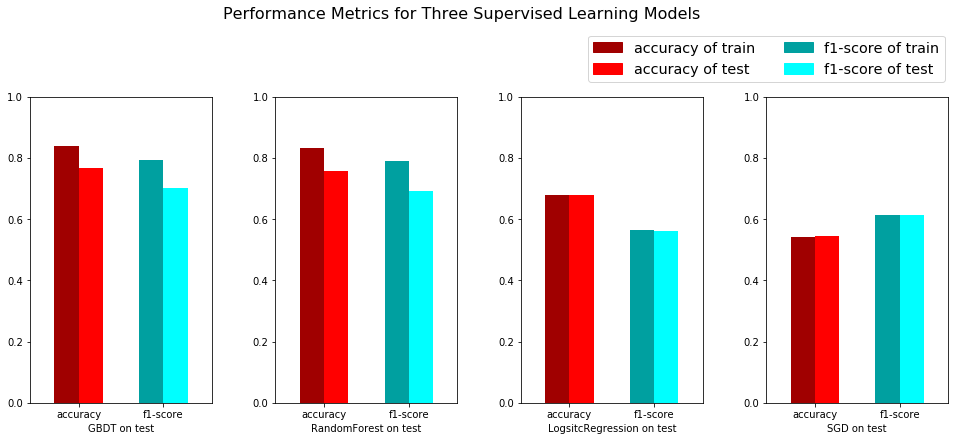

In [120]:
show_tables(performance_result)

In [22]:
print(performance_result)

{'LogsitcRegression': {'train': {'f1-score': 0.5780675818373813, 'accuracy': 0.6821696177158402}, 'test': {'f1-score': 0.5784203174175742, 'accuracy': 0.6812090359529113}}, 'RandomForest': {'train': {'f1-score': 0.7920917987183946, 'accuracy': 0.8335401454047948}, 'test': {'f1-score': 0.6919929307242823, 'accuracy': 0.7538020999045498}}, 'SGD': {'train': {'f1-score': 0.6495222405271829, 'accuracy': 0.6615599993636552}, 'test': {'f1-score': 0.6481995188199255, 'accuracy': 0.6594463888005091}}, 'GBDT': {'train': {'f1-score': 0.7939010391800331, 'accuracy': 0.838614995466043}, 'test': {'f1-score': 0.7016492239898908, 'accuracy': 0.7656251988545976}}}


In [6]:
import _pickle as pk

gbdt_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=140, max_depth=14, min_samples_split=550,
                                    max_features='sqrt', subsample=0.85, random_state=rand_number)
gbdt_clf.fit(input_data, result)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=14,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=550,
              min_weight_fraction_leaf=0.0, n_estimators=140,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.85, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [8]:
pk.dump(gbdt_clf, open("gbdt.pickle", "wb"))

In [ ]:
start_time = time()
gbdt_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150, max_depth=14, min_samples_split=550,
                                    max_features='sqrt', subsample=0.85, random_state=rand_number)
gbdt_clf.fit(X_train, y_train)
importances = gbdt_clf.feature_importances_
indices = np.argsort(importances)[::-1]
end_time = time()

cost = end_time - start_time
print("time to train: %f" % cost)

In [23]:
feat_labels = X_train.columns
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) norm_wmd                       0.228443
 2) wmd                            0.091929
 3) fuzz_partial_ratio             0.074963
 4) fuzz_qratio                    0.066617
 5) common_words                   0.043307
 6) fuzz_token_set_ratio           0.042849
 7) cosine_distance                0.037364
 8) fuzz_token_sort_ratio          0.035086
 9) len_q1                         0.025339
10) len_q2                         0.024063
11) minkowski_distance             0.023459
12) skew_q1vec                     0.021674
13) skew_q2vec                     0.021243
14) cityblock_distance             0.020212
15) kur_q2vec                      0.019815
16) len_word_q2                    0.019534
17) euclidean_distance             0.019007
18) kur_q1vec                      0.017693
19) len_q_ratio_ln                 0.017242
20) canberra_distance              0.016789
21) fuzz_partial_token_sort_ratio  0.016293
22) len_word_q_ratio_ln            0.016172
23) len_word_q1                 

In [26]:
model = gbdt_clf
y_predprob = model.predict(X_train)

y_t = model.predict(X_test)
res = [roc_auc_score(y_train, y_predprob), roc_auc_score(y_test, y_t), 
       fbeta_score(y_train, y_predprob, beta=1), fbeta_score(y_test, y_t, beta=1),
       accuracy_score(y_train, y_predprob), accuracy_score(y_test, y_t)
      ]
print(res)

[0.8374969818670776, 0.7601650316255187, 0.7939010391800331, 0.7016492239898908, 0.838614995466043, 0.7656251988545976]


In [14]:
def show_bars(results, bar_width=0.4):
    m_num = len(results.keys())
    data_set = ["train", "test"]
    metric_set = ['logloss']
    
    # Create figure
    fig, ax = pl.subplots(1, m_num, figsize=(15, 5))

    # Constants
    colors = ['#00A0A0', '#00ffff', '#A00000', '#ff0000']

    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for m_num, metric in enumerate(metric_set):
            for i, set_name in enumerate(data_set):
                # Creative plot code
                ax[k].bar(m_num*1 + i*bar_width - bar_width,
                          results[learner][set_name][metric],
                          width=bar_width, color=colors[m_num*2 + i])
        ax[k].set_xticks(list(range(len(metric_set))))
        ax[k].set_xticklabels(metric_set)
        ax[k].set_xlabel("{l} on {t}".format(l=learner, t=set_name))
        ax[k].set_xlim(0, len(metric_set)+1)
        ax[k].set_ylim(0,12)

    # Create patches for the legend
    patches = []
    for m_num, metric_s in enumerate(metric_set):
        for i, data_s in enumerate(data_set):
            patches.append(mpatches.Patch(color=colors[m_num*2 + i], label="%s of %s" % (metric_s, data_s)))
    pl.legend(handles=patches, bbox_to_anchor=(0, 1.2),
              loc='upper center', borderaxespad=0., ncol=2, fontsize='x-large')

    # Aesthetics
    pl.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize=16, y=1.10)
    pl.subplots_adjust(top=0.85, bottom=0., left=0.10, right=0.95, hspace=0.3, wspace=0.35)
    pl.show()

    
from multi_process import process_data

def train_test_models_logloss(l):
    result = {}
    for clf, name in l:
        print("start train %s" % name)
        train_dict = {}
        t_start = time()
        clf.fit(X_train, y_train)
        t_end = time()
        print("time cost for model %s: %f" % (name, (t_end - t_start)))
#         y_train_pred = process_data(clf.predict, X_train, n=8, tag="train prediction of %s" % name)
        y_train_pred = clf.predict(X_train)
        train_dict["logloss"] = get_log_loss(y_train, y_train_pred)
        print("start test %s" % name)
        test_dict = {}
#         y_test_pred = process_data(clf.predict, X_test, n=8, tag="test prediction of %s" % name)
        y_test_pred = clf.predict(X_test)
        test_dict["logloss"] = get_log_loss(y_test, y_test_pred)
        result[name] = {"train": train_dict, "test": test_dict}
    print("train_test done")
    return result

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=90, max_depth=20, min_samples_split=30, max_features="auto",
                             min_samples_leaf=10, random_state=rand_number)
gbdt_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=140, max_depth=14, min_samples_split=550,
                                    max_features='sqrt', subsample=0.85, random_state=rand_number)
lr_clf = LogisticRegression(penalty='l2', solver='newton-cg', n_jobs=5, C=1)
sgd_clf = SGDClassifier(max_iter=100, tol=0.0001, penalty='l1', loss="modified_huber"
                       , n_jobs=5, random_state=rand_number)
lgb_clf = LGBMClassifier(n_jobs=8, max_depth=20, num_leaves=50, learning_rate=0.1, lambda_l1=0.3,lambda_l2=8)
models=[(rf_clf, "RandomForest"), (gbdt_clf, "GBDT"), (lr_clf, "LogsitcRegression"), (sgd_clf, "SGD"), (lgb_clf, "lightGBM")]

rs = train_test_models_logloss(models)
show_bars(rs)
print(rs)

start train RandomForest
time cost for model RandomForest: 383.288692
start test RandomForest
start train GBDT
time cost for model GBDT: 997.634159
start test GBDT
start train LogsitcRegression


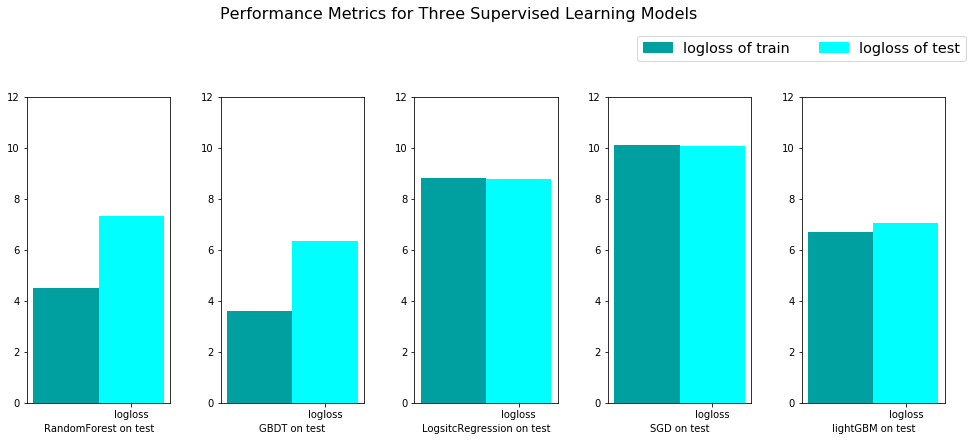

In [13]:
show_bars(rs)

In [14]:

lgb_clf = LGBMClassifier(n_jobs=8)

models=[(lgb_clf, "lightGBM")]

In [ ]:
rs = train_test_models(models)
show_bars(rs)
print(rs)

start train RandomForest
